# Figure 3

This notebook is used to reproduce Figure 3 of [PHYSICAL REVIEW B 98, 094104 (2018)](https://doi.org/10.1103/PhysRevB.98.094104)

* Author: Xin Chen
* Date: Jan 22, 2019

In [2]:
import numpy as np
import ase
import os
import shutil

from os.path import exists, join
from ase.build import bulk
from ase import Atoms
from ase.calculators.vasp import Vasp2
from ase.calculators.calculator import all_changes
from ase.io import read
from tensoralloy.calculator import TensorAlloyCalculator

from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

## 1. Bulk Nickel

Create the conventional **fcc** cubic bulk of **Ni**.

In [24]:
base_atoms = bulk('Ni', crystalstructure='fcc', cubic=True)
scaled_positions = base_atoms.get_scaled_positions()
symbols = base_atoms.get_chemical_symbols()

## 2. Relaxation of the fcc Ni

This is a helper function returning the command to run VASP.

In [25]:
def get_vasp_command():
    with open("run_vasp.sh") as fp:
        content = fp.read()
    return " && ".join([x for x in content.split('\n') if not x.strip().startswith('#')])

Define the top directory for all VASP calculations related to Fig 3.

In [26]:
vasp_dir = 'vasp_fig3'
if not exists(vasp_dir):
    os.makedirs(vasp_dir)

**Relax** the cell shape and volume of **base_atoms** using VASP.

In [27]:
base_dir = join(vasp_dir, 'base')

if not exists(base_dir):
    calc = Vasp2(
        directory=base_dir, 
        xc='pbe', 
        command=get_vasp_command())

    calc.set(istart=0, icharg=1, ismear=0, sigma=0.05, isif=2, prec='high', 
             encut=520, nsw=0, nelm=99, ediff=1E-7, ediffg=-0.002, ibrion=-1, 
             ispin=2, lreal=False, kspacing=0.1, magmom=(5.0, 5.0, 5.0, 5.0),
             setups={'Ni': '_pv'})

    base_atoms.calc = calc
    calc.calculate(base_atoms)

else:
    base_atoms = read(join(base_dir, 'OUTCAR'), format='vasp-out')

print("The optimized cell is: ")
print(base_atoms.cell)
print(f"The optimized volume is: {base_atoms.get_volume()}")
print(f"The total energy is: {base_atoms.get_potential_energy()}")

The optimized cell is: 
[[3.52 0.   0.  ]
 [0.   3.52 0.  ]
 [0.   0.   3.52]]
The optimized volume is: 43.61420799999998
The total energy is: -23.11428258


## 3. NN/EAM Results

### 3.1 Load NN and EAM calculators

* `zjw04`: The original Zjw04 EAM calculator
* `zjw04xc`: The machine-learning optimized continous Zjw04 EAM calcualtor
* `behler`: The Behler's symmetry function based atomistic neural network calculator

In [28]:
zjw04 = TensorAlloyCalculator('Ni.zjw04.pb')
zjw04xc = TensorAlloyCalculator('Ni.zjw04xc.pb')
behler = TensorAlloyCalculator('Ni.behler.k2.pb')

### 3.2 Calculate

The volume ranges from 83% to 121%.

In [29]:
delta = {
    'zjw04': [], 
    'zjw04xc': [],
    'behler': [],
    'dft': [],
}
ref = {
    'zjw04': zjw04.get_potential_energy(base_atoms),
    'zjw04xc': zjw04xc.get_potential_energy(base_atoms),
    'behler': behler.get_potential_energy(base_atoms),
    'dft': calc.results['energy'],
}
volume = []
list_of_atoms = []
list_of_atoms_id = []

for atoms_id in range(-17, 22, 1):
    percent = float(atoms_id)
    cell = base_atoms.cell * (1.0 + percent * 0.01)**(1.0/3.0)
    atoms = Atoms(symbols, pbc=True, cell=cell, scaled_positions=scaled_positions)
    volume.append(atoms.get_volume())
    list_of_atoms.append(atoms)
    list_of_atoms_id.append(atoms_id)
    delta['zjw04'].append(zjw04.get_potential_energy(atoms) - ref['zjw04'])
    delta['zjw04xc'].append(zjw04xc.get_potential_energy(atoms) - ref['zjw04xc'])
    delta['behler'].append(behler.get_potential_energy(atoms) - ref['behler'])

## 4. DFT Results

### 4.1 Create Input Files

The DFT calculations should be done on computational nodes as they requires a lot of time to finish.

In [31]:
for atoms_id, atoms in zip(list_of_atoms_id, list_of_atoms):
    dft = Vasp2(
        directory=join(vasp_dir, str(atoms_id)), 
        xc='pbe', 
        command=get_vasp_command())
    dft.set(istart=0, icharg=1, ismear=0, sigma=0.05, isif=2, prec='high',
            encut=520, ediff=1E-8, ispin=2, lreal=False, kspacing=0.1,
            magmom=(5.0, 5.0, 5.0, 5.0), ibrion=-1, nelm=99, nsw=0, setups={'Ni': '_pv'})
    dft.write_input(atoms, ['energy'], all_changes)

### 4.2 Read Outputs

In [32]:
for atoms_id in list_of_atoms_id:
    if atoms_id == 0:
        delta['dft'].append(0)
    else:
        atoms = read(join(vasp_dir, str(atoms_id), 'OUTCAR'), format='vasp-out')
        delta['dft'].append(atoms.get_potential_energy() - ref['dft'])

## 5. Plot

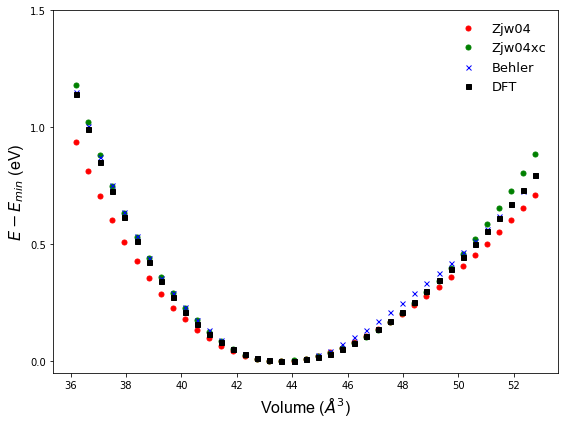

In [43]:
fig, ax = plt.subplots(1, 1, figsize=[8, 6])

h1, = ax.plot(volume, delta['zjw04'], '.', markersize=10, color='red')
h2, = ax.plot(volume, delta['zjw04xc'], 'o', markersize=5, color='green')
h3, = ax.plot(volume, delta['behler'], 'x', markersize=5, color='blue')
h4, = ax.plot(volume, delta['dft'], 's', markersize=5, color='black')

ax.set_xlabel(r"Volume ($\AA^3$)", fontsize=16, fontname='arial')
ax.set_ylabel(r"$E - E_{min}$ (eV)", fontsize=16, fontname='arial')
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(0.5))

ax.set_ylim([-0.05, 1.5])

plt.legend(
    [h1, h2, h3, h4], 
    ['Zjw04', 'Zjw04xc', 'Behler', 'DFT'], 
    frameon=False, fontsize=13)
plt.tight_layout()
plt.savefig('fig3.png', dpi=300)
plt.show()